# Multifractal Detrended Moving Average (MF-DMA) Module

Reference:

Gu, Gao-Feng Gu, and Wei-Xing Zhou. "Detrending moving average algorithm for multifractals." Physical Review E, no. 82, 2010, pp. 011136,

Arianos, Sergio, and Anna Carbone. "Detrending moving average algorithm: A closed-form approximation of the scaling law." Physica A, no. 382, 2007, pp. 9–15

In [1]:
import array
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
files = 'https://raw.githubusercontent.com/y3kiys4/wqu_capstone_june2023_grp3626/main/SPX_1m_Dec2020_Jun2023.csv'

df = pd.read_csv(files)
# Set timestamp as index
df = df.set_index(df['Time'])
df.drop(['Time'], axis=1, inplace=True)
df.index = pd.to_datetime(df.index)

# Calculate log return
df['log_ret'] = 10000 * np.log(df.Price).diff() # 10,000 times log return

# Calculate the time difference in mininutes
df['deltaT'] = (df.index.to_series().diff().dt.days.mul(60*24, fill_value=0) +
                df.index.to_series().diff().dt.seconds.div(60, fill_value=0)
               )

df_1min = df[df['deltaT'] == 1]
df_1min['log_ret_sq'] = np.square(df_1min['log_ret'])
df_1min

C:\Users\cutef\AppData\Local\Temp\ipykernel_7284\374198705.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1min['log_ret_sq'] = np.square(df_1min['log_ret'])


,Price,log_ret,deltaT,log_ret_sq
Time,,,,
2020-12-01 00:01:00,3654.045,1.932292,1.0,3.733753
2020-12-01 00:02:00,3654.336,0.796346,1.0,0.634167
2020-12-01 00:03:00,3653.945,-1.070019,1.0,1.144941
2020-12-01 00:04:00,3653.845,-0.273681,1.0,0.074901
2020-12-01 00:05:00,3653.299,-1.494428,1.0,2.233315
...,...,...,...,...
2023-06-30 16:09:00,4446.311,-1.171689,1.0,1.372856
2023-06-30 16:10:00,4445.570,-1.666689,1.0,2.777852
2023-06-30 16:11:00,4445.332,-0.535379,1.0,0.286630


## 1. Construct the sequence of cumulative sums

<AxesSubplot:xlabel='Time'>

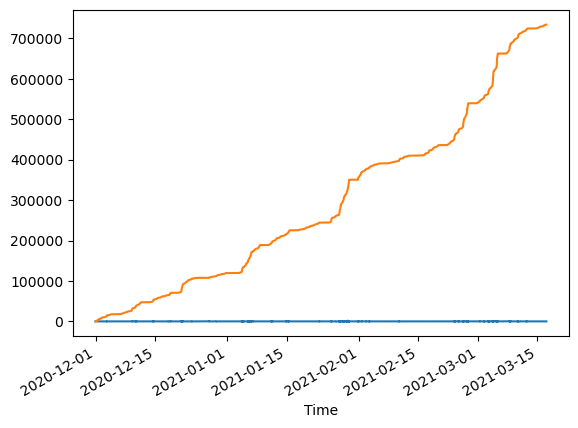

In [3]:
n_sample = 60 * 24 * 22 * 3 # sample is 3-month-equivalent dataset

cs = pd.DataFrame(df_1min['log_ret_sq'][:n_sample], columns = ['log_ret_sq'])
cs['cum_sum'] = cs['log_ret_sq']
cs['cum_sum'] = cs['cum_sum'].cumsum()

cs['log_ret_sq'].plot()
cs['cum_sum'].plot()

In [4]:
cs

,log_ret_sq,cum_sum
Time,,
2020-12-01 00:01:00,3.733753,3.733753
2020-12-01 00:02:00,0.634167,4.367920
2020-12-01 00:03:00,1.144941,5.512860
2020-12-01 00:04:00,0.074901,5.587761
2020-12-01 00:05:00,2.233315,7.821076
...,...,...
2021-03-17 02:25:00,1.518706,734155.463935
2021-03-17 02:26:00,0.286569,734155.750504
2021-03-17 02:27:00,0.573778,734156.324282


## In the for-loop:
### 2. Calculate moving average
### 3. Detrend
### 4. Define non-overlapping segments and calculate each fluctuation variance
### 5. Calculate q-th order fluctuation function

In [5]:
# Define parameters
lags = np.unique(np.logspace(0.5, 3, 25).astype(int))
qs = [-10, -5, -2, 2, 5, 10]
total_epoch = len(lags) * len(qs)
len_total = len(cs['cum_sum'])

# Create DMA flucuation function dataframe
F_summary_columns = []
for q in qs:
    F_summary_columns.append('q_'+str(q))

F_summary_index = []
for l in lags:
    F_summary_index.append('n_'+str(l))

F_summary = pd.DataFrame(index=F_summary_index, columns=F_summary_columns)

In [6]:
print(f'Total epochs is {total_epoch}, estimated time is {int(total_epoch/6/3)} min') # spend 20 sec per 6 epochs
starttime_total = time.time()
starttime_epoch = time.time()

epoch = 0
for lag in lags:
    mean_temp = []
    # Calculate moving average
    for i in range(len(cs['cum_sum'])-lag+1):
        mean_temp.append(np.mean(cs['cum_sum'][i:i+lag]))
    mean_temp.reverse()

    # Detrend
    diff_temp_subtractor = cs['cum_sum'][:lag-2:-1].values
    diff_temp = np.subtract(np.array(mean_temp), diff_temp_subtractor)

    # Slice into non-overlapping segments
    segs_temp = pd.DataFrame(np.resize(diff_temp, (len(diff_temp) // lag, lag))).T

    # Calculate fluctuation variance
    F_seg_sq_temp = np.array(np.var(segs_temp).mean(axis=0)) 

    for q in qs:
        # Calculate the qth order fluctuation function
        F_temp =  ((1 / lag) * (F_seg_sq_temp ** (q / 2)).sum()) ** (1 / q)
        F_summary.loc[str('n_'+str(lag))][str('q_'+str(q))] = F_temp
        epoch += 1
        
    print(f'Epoch {epoch} is done')
        
endtime_total = time.time()        
total_time = endtime_total - starttime_total
print(f'Total time spent is {int((endtime_total-starttime_total)//60)} min {int((endtime_total-starttime_total) % 60)} sec(s)')

Total epochs is 150, estimated time is 8 min
Epoch 6 is done
Epoch 12 is done
Epoch 18 is done
Epoch 24 is done
Epoch 30 is done
Epoch 36 is done
Epoch 42 is done
Epoch 48 is done
Epoch 54 is done
Epoch 60 is done
Epoch 66 is done
Epoch 72 is done
Epoch 78 is done
Epoch 84 is done
Epoch 90 is done
Epoch 96 is done
Epoch 102 is done
Epoch 108 is done
Epoch 114 is done
Epoch 120 is done
Epoch 126 is done
Epoch 132 is done
Epoch 138 is done
Epoch 144 is done
Epoch 150 is done
Total time spent is 5 min 5 sec(s)


In [7]:
F_summary

,q_-10,q_-5,q_-2,q_2,q_5,q_10
n_3,15.671339,17.491145,24.319498,8.106499,11.271189,12.580035
n_4,20.414658,23.450284,35.543984,8.885996,13.468651,15.471418
n_5,24.242208,28.475356,46.148774,9.229755,14.958263,17.570259
n_6,27.049781,32.357792,55.389094,9.231516,15.80223,18.903121
n_8,33.143177,40.804037,76.143025,9.517878,17.760989,21.866342
n_10,39.063572,49.178124,98.123257,9.812326,19.578164,24.647448
n_13,48.736173,62.98625,135.965512,10.458886,22.577113,29.178486
n_16,58.096927,76.659355,176.11695,11.007309,25.288156,33.367922
n_21,72.582355,98.413117,245.311989,11.681523,29.11825,39.480914
n_27,89.377816,124.269948,334.022133,12.37119,33.252217,46.233523


## 6. Calculate Hurst exponent

In [8]:
log10_lag = np.log10(lags)
log10_F = np.log10(np.array(F_summary['q_2']).astype(float)) 
hurst_hat = np.polyfit(log10_lag, log10_F, 1)[0]
print(f'The estimated Hurst exponent is {hurst_hat}')

The estimated Hurst exponent is 0.3856961322032425


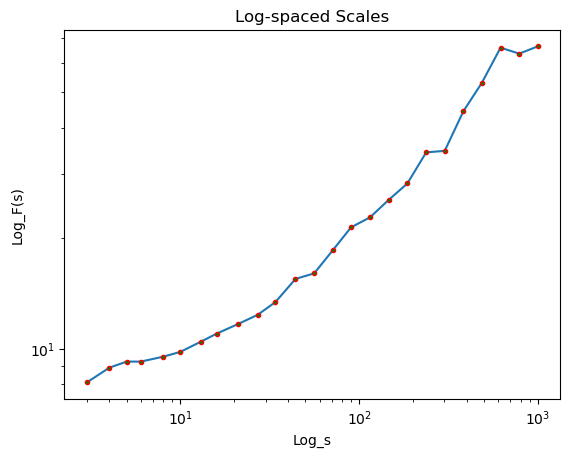

In [10]:
plt.loglog(lags, F_summary['q_2'], marker="o", markersize=3, markeredgecolor="red", markerfacecolor="green")
plt.xlabel('Log_s')
plt.ylabel('Log_F(s)')
plt.title('Log-spaced Scales')
plt.show()